# Exercise 4: Short-time Fourier Transform

Doing this exercise you will learn about the concept of the main lobe width of the spectrum of a window and you will better understand the short-time Fourier transform (STFT). You will also use the STFT to extract basic rhythm related information from an audio signal, implementing an onset detection function, which is one of the rhythm descriptors often used in music information retrieval to detect onsets of acoustic events. 

There are four parts in this exercise. 1) Extracting the main lobe of the spectrum of a window, 2) Measuring noise in the reconstructed signal using the STFT model, 3) Computing band-wise energy envelopes of a signal, 4) Computing an onset detection function.


### Relevant Concepts

__Main lobe of the spectrum of a window:__
The width of the main lobe of the magnitude spectrum of a window is an important characteristic used in deciding which window type is best for the analysis of an audio excerpt. There exists a tradeoff between the main lobe width and the side lobe attenuation. Typically for windows with a narrower main lobe, the side lobes are less attenuated. 
An interesting fact is that changing the length of a window $M$ doesn't affect the main lobe width of the spectrum of the window in samples. Note that if you use zero-padding for computing the spectrum of a window, the main lobe width will be multiplied by the zero-padding factor.

__Fast Fourier Transform (FFT):__
An efficient way to compute the discrete Fourier transform of a signal is the fast Fourier transform, FFT. The FFT algorithm  factorizes the DFT matrix in order to exploit the symmetries in the DFT equation. FFT computation is specially very efficient when the FFT size is a power of 2. Therefore, whenever possible we use an FFT size that is a power of 2.

__Energy of a signal:__ The energy of a signal $x[n]$ of length $N$ can be computed in the discrete time domain as follows:
\begin{equation}
E=\overset{N-1}{\underset{n=0}{\sum}}\left|x\left[n\right]\right|^{2}
\end{equation}

__Energy in a frequency band:__ Given the DFT spectrum of the signal $X[k]$, the energy $E$ in a specific frequency band spanning the bin index $k_1$ to $k_2$ can be computed as:

\begin{equation}
E=\overset{k_{2}}{\underset{k=k_{1}}{\sum}}\left|X\left[k\right]\right|^{2}
\end{equation}

Note that in this computation the $X[k]$ values are not in decibels (dB). The `stftAnal()` function returns magnitude spectra in dB scale, which should be converted to linear scale before the energy computation. Once the energy is computed it can be converted back to the dB scale as:

\begin{equation}
E_{dB}= 10\,\log_{10}(E)
\end{equation}

__Signal to noise ratio (SNR):__
Signal to noise ratio (SNR) is a frequently used measure to quantify the amount of noise present/added in a signal. In the context of this exercise it can be computed in decibels (dB) as:

\begin{equation}
\mathrm{SNR} = 10\,\log_{10}\left(\frac{E_{\mathrm{signal}}}{E_{\mathrm{noise}}}\right)
\end{equation}

where, $E_{\mathrm{signal}}$ and $E_{\mathrm{noise}}$ are the energy of the signal and noise respectively.

For our case of analysis and synthesis using a specific model (for example, STFT) noise can be thought of as the difference between the input signal and the output signal of the model.

__Onset detection function:__
An onset detection function (ODF) refers to a continuous function (one value per audio frame) often used for detecting acoustic events in an audio stream. In music information retrieval (MIR), ODFs are typically used for detecting onsets of musical notes and percussion strokes. An ODF generally has high values at the onsets of acoustic events. A simple ODF can be computed by taking the difference between the energy values of consecutive frames, as shown below:

\begin{equation}
O(l) = E(l) - E(l-1) ,\,\,\,\,\, l \geq 1
\end{equation}

where, $O(l)$ is the ODF computed at frame index $l$ and $E$ is the energy of the signal in a particular frequency band in decibels (dB). Often, multiple ODFs are computed with different frequency bands across the spectrum. 

In order to detect only the onsets of the events and not the offsets, it is a common practice to half wave rectify the ODF and obtain $\bar{O}(l)$. Half wave rectification of the ODF is given by:

 \begin{equation}
 \bar{O}(l)=\begin{cases}
 \begin{array}{c}
 O(l), \, \mathrm{if} \,\,O(l)>0\\
 \,\,\,\,0, \,\,\,\,\, \mathrm{if} \,\, O(l)\leq0
 \end{array}\end{cases} 
 \end{equation}

## Part 1 - Extracting the main lobe of the spectrum of a window

The function `extract_main_lobe()` should extract the main lobe of the magnitude spectrum of a window given a window type, `window`, and its length, `M`. The function should return the samples corresponding to the main lobe in decibels (dB).

To compute the spectrum you should take the FFT size (`N`) to be 8 times the window length (`N = 8*M`) (For this part, `N` does not need to be a power of 2). 

The input arguments to the function are the window type (`window`) and the length of the window (`M`). The function should return a numpy array containing the samples corresponding to the main lobe of the window. In the returned numpy array you should include the samples corresponding to both the local minimas across the main lobe. 

The possible window types that you can expect as input are rectangular (`'boxcar'`), `'hamming'` or `'blackmanharris'`.

NOTE: You can approach this task by writing code to find the indices of the local minimas across the main lobe.

_Tip:_ `log10(0)` is not well defined, so its a common practice to add a small value such as `eps = 1e-16` to the magnitude spectrum before computing it in dB. This is optional and will not affect your answers. 
If you find it difficult to concatenate the two halves of the main lobe, you can first center the spectrum using `fftshift()` and then compute the indexes of the minimas around the main lobe.

In [1]:
import os
import sys
import numpy as np

from scipy.signal import get_window
from scipy.fftpack import fft, fftshift

import math
import matplotlib.pyplot as plt
%matplotlib notebook
eps = np.finfo(float).eps

sys.path.append('../software/models/')
import stft
import utilFunctions as UF

In [2]:
# E4 - 1.1: Complete function extract_main_lob()

def extract_main_lobe(window, M, N):
    """Extract the main lobe of the magnitude spectrum of a window, given a window type and its length.
    
    Args:
        window (str): Window type to be used (either rectangular ('boxcar'), 'hamming' or 'blackmanharris')
        M (int): length of the window to be used
        N (int): size of FFT
        
    Results:
        np.array: an array containing the main lobe of the magnitude spectrum of the window in decibels (dB).
    """

    w = get_window(window, M)                                       # Get the window 
    
    ### Your code here
    
    hM1 = int(math.floor((M+1)/2))                                  # End value of first half of zero-phase windowed signal                               
    hM2 = int(math.floor(M/2))                                      # Start value of second half of zero-phase windowed signal
    hN = N//2 + 1                                                   # Size of half the spectrum, including sample 0
    
    # Do zero-phase windowing (with zero padding)
    fftbuffer = np.zeros(N)                                       
    fftbuffer[:hM1] = w[hM2:]                                     
    fftbuffer[N-hM2:] = w[:hM2]
    
    # Compute DFT of window
    W = fft(fftbuffer)
    
    # Compute magnitude spectrum
    absW = abs(W)                                                   
    absW[absW<np.finfo(float).eps] = np.finfo(float).eps            # Avoid log10(0) before converting mag spectrum to dB
    mW = 20*np.log10(absW)                                          # Convert magnitude spectrum to dB
    
    # Center the spectrum
    mW1 = fftshift(mW)
    
    # Locate index of maximum value of magnitude spectrum in order to find the local minimas around it
    idxmax_mW1 = np.argmax(mW1)
    
    idxL = 1                                                        # Initialize moving index to the left of the main lobe peak
    lVal1 = mW1[idxmax_mW1-idxL]                                    # Variable inspecting the left half of main lobe
    lVal2 = mW1[idxmax_mW1-(idxL+1)]                                # Second variable running one sample to the left of lVal1
    
    # The main lobe ends when lVal2 has a value higher than lVal1 (left local minima was found)
    while lVal1 >= lVal2:                                           # If the first variable has a higher value than the second, we are still passing through the main lobe                                   
        idxL += 1                                                   # Advance one sample to the left
        lVal1 = mW1[idxmax_mW1-idxL]                                # Update first variable
        lVal2 = mW1[idxmax_mW1-(idxL+1)]                            # Update second variable
    
    # When the loop ends we have the index of the left local minima. 
    # We know the index of the right one because of the symmetry.
    mainLobe = mW1[idxmax_mW1-idxL:idxmax_mW1+idxL+1] 
    
    return mainLobe                                                 # Return main lobe
  

Test cases for the function `extract_main_lobe()`:

_Test case 1:_ If you run your code using `window = 'blackmanharris'`, `M = 100` and `N = 800`, the output numpy array should contain 65 samples.

_Test case 2:_ If you run your code using `window = 'boxcar'`, `M = 120` and `N = 960`, the output numpy array should contain 17 samples.

_Test case 3:_ If you run your code using `window = 'hamming`, `M = 256`, and `N = 2048`, the output numpy array should contain 33 samples.

To understand better the result you can plot the magnitude spectrum of the window and mark the boundaries of the main lobe.

<IPython.core.display.Javascript object>


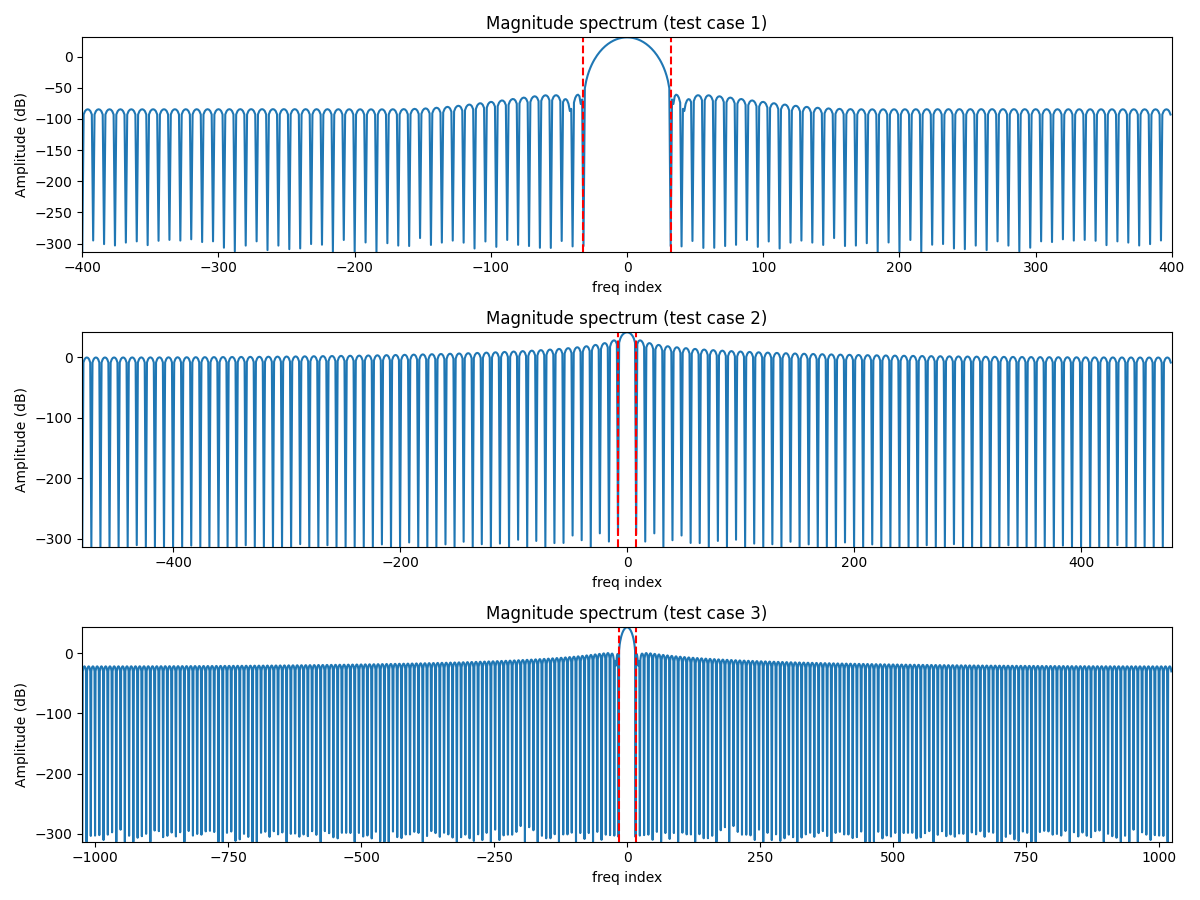

Length of main lobe (test case 1):  65
Length of main lobe (test case 2):  17
Length of main lobe (test case 3):  33


<IPython.core.display.Javascript object>


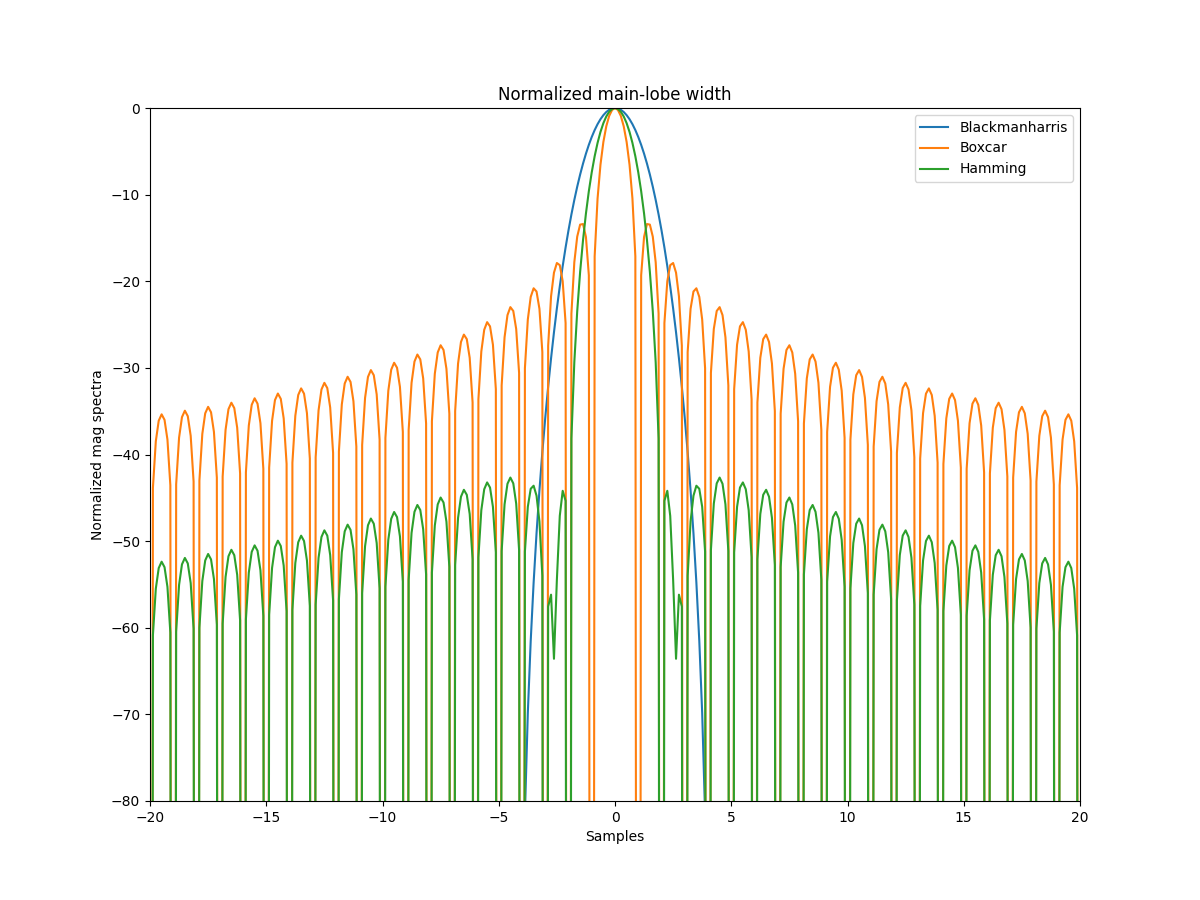

For the Blackmanharris window, we can see in the graph that the main lobe spans to 3.9 samples for each side of the peak, resulting in a main lobe width of approximately 8 bins, which agrees with the theory.
For the Boxcar window (rectangular), we can see in the graph that the main lobe spans to 0.9 samples for each side of the peak, resulting in a main lobe width of approximately 2 bins, which coincides with the theory.
For the Hamming window, we can see in the graph that the main lobe spans to 1.9 samples for each side of the peak, resulting in a main lobe width of approximately 4 bins, which matches the theory.


In [3]:
# E4 - 1.2: Call extract_main_lobe() with the 3 test cases mentioned and plot the magnitude spectra of the windows with 
# the location of the main-lobe boundaries. Compute and explain the normalized main-lobe width (dividing by the 
# zero-padding factor), comparing it with the values presented in the theory.

### Your code here

### ------------------------ TEST CASE 1 ---------------------------- ###
# Parameters for test case 1
M1 = 100                                                       # Window size
N1 = 800                                                       # FFT size
w = get_window('blackmanharris', M1)                           # Build Blackmanharris window

# Call extract_main_lobe() function
mainLobe1 = extract_main_lobe(window='blackmanharris', M=M1, N=N1)             

# Do zero-phase windowing with zero padding to compute magnitude spectrum
hM1 = int(math.floor((M1+1)/2))                                                                
hM2 = int(math.floor(M1/2))                                    
hN1 = N1//2 + 1                                                
fftbuffer = np.zeros(N1)                                       
fftbuffer[:hM1] = w[hM2:]                                     
fftbuffer[N1-hM2:] = w[:hM2]
    
# Compute DFT of window
W = fft(fftbuffer)

# Compute magnitude spectrum
absW = abs(W)                                                  
absW[absW<np.finfo(float).eps] = np.finfo(float).eps           # Avoid log10(0) before converting mag spectrum to dB
mW = 20*np.log10(absW)                                         # Convert to dB

# Center the spectrum
mW1 = fftshift(mW)

locLocalMinima = np.where(mW1 == mainLobe1[0])                 # Find the left boundary of the main lobe (and the right boundary also by symmetry)
locLeftLine = int(locLocalMinima[0][0]) - N1//2                # Location in the plot of the left boundary of the main lobe
locRightLine = int(locLocalMinima[0][1]) - N1//2               # Location in the plot of the right boundary of the main lobe

# Plot the magnitude spectrum marking the main lobe boundaries
plt.figure(figsize=(12,9))

plt.subplot(3,1,1)
plt.plot(np.arange(-N1/2, N1/2), mW1)
plt.axis([-N1/2, N1/2, min(mW1), max(mW1)])
plt.title('Magnitude spectrum (test case 1)')
plt.xlabel('freq index')
plt.ylabel('Amplitude (dB)')
plt.axvline(x=locLeftLine, color='red', linestyle='--')
plt.axvline(x=locRightLine, color='red', linestyle='--')


### ------------------------ TEST CASE 2 ---------------------------- ###
# Parameters for test case 2
M2 = 120                                                       # Window size
N2 = 960                                                       # FFT size
w = get_window('boxcar', M2)                                   # Build Boxcar window

# Call extract_main_lobe() function
mainLobe2 = extract_main_lobe(window='boxcar', M=M2, N=N2)

# Do zero-phase windowing with zero padding to compute magnitude spectrum
hM1 = int(math.floor((M2+1)/2))                                                                
hM2 = int(math.floor(M2/2))                                    
hN2 = N2//2 + 1                                                
fftbuffer = np.zeros(N2)                                       
fftbuffer[:hM1] = w[hM2:]                                     
fftbuffer[N2-hM2:] = w[:hM2]
    
# Compute DFT of window
W = fft(fftbuffer)

# Compute magnitude spectrum
absW = abs(W)                                                  
absW[absW<np.finfo(float).eps] = np.finfo(float).eps          # Avoid log10(0) before converting mag spectrum to dB
mW = 20*np.log10(absW)                                        # Convert to dB

# Center the spectrum
mW2 = fftshift(mW)

locLocalMinima = np.where(mW2 == mainLobe2[0])                # Find the left boundary of the main lobe (and the right boundary due to symmetry)
locLeftLine = int(locLocalMinima[0][0]) - N2//2               # Location in the plot of the left boundary of the main lobe
locRightLine = int(locLocalMinima[0][1]) - N2//2              # Location in the plot of the right boundary of the main lobe

# Plot the magnitude spectrum marking the main lobe boundaries
plt.subplot(3,1,2)
plt.plot(np.arange(-N2/2, N2/2), mW2)
plt.axis([-N2/2, N2/2, min(mW2), max(mW2)])
plt.title('Magnitude spectrum (test case 2)')
plt.xlabel('freq index')
plt.ylabel('Amplitude (dB)')
plt.axvline(x=locLeftLine, color='red', linestyle='--')
plt.axvline(x=locRightLine, color='red', linestyle='--')


### ------------------------ TEST CASE 3 ---------------------------- ###
# Parameters for test case 3
M3 = 256                                                      # Window size
N3 = 2048                                                     # FFT size
w = get_window('hamming', M3)                                 # Build Hamming window

# Call extract_main_lobe() function
mainLobe3 = extract_main_lobe(window='hamming', M=M3, N=N3)

# Do zero-phase windowing with zero padding to compute magnitude spectrum
hM1 = int(math.floor((M3+1)/2))                                                                
hM2 = int(math.floor(M3/2))                                    
hN3 = N3//2 + 1                                                
fftbuffer = np.zeros(N3)                                       
fftbuffer[:hM1] = w[hM2:]                                     
fftbuffer[N3-hM2:] = w[:hM2]
    
# Compute DFT of window
W = fft(fftbuffer)

# Compute magnitude spectrum
absW = abs(W)                                                  
absW[absW<np.finfo(float).eps] = np.finfo(float).eps           # Avoid log10(0) before converting mag spectrum to dB
mW = 20*np.log10(absW)                                         # Convert to dB

# Center the spectrum
mW3 = fftshift(mW)

locLocalMinima = np.where(mW3 == mainLobe3[0])                 # Find the left boundary of the main lobe (and the right boundary due to symmetry)
locLeftLine = int(locLocalMinima[0][0]) - N3//2                # Location in the plot of the left boundary of the main lobe
locRightLine = int(locLocalMinima[0][1]) - N3//2               # Location in the plot of the right boundary of the main lobe

# Plot the magnitude spectrum marking the main lobe boundaries
plt.subplot(3,1,3)
plt.plot(np.arange(-N3/2, N3/2), mW3)
plt.axis([-N3/2, N3/2, min(mW3), max(mW3)])
plt.title('Magnitude spectrum (test case 3)')
plt.xlabel('freq index')
plt.ylabel('Amplitude (dB)')
plt.axvline(x=locLeftLine, color='red', linestyle='--')
plt.axvline(x=locRightLine, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Show the length (in samples) of the three main lobes
print("Length of main lobe (test case 1): ", len(mainLobe1))
print("Length of main lobe (test case 2): ", len(mainLobe2))
print("Length of main lobe (test case 3): ", len(mainLobe3))

# Plot all the magnitude spectra together normalizing the axis
plt.figure(figsize=(12,9))
plt.plot(np.arange(-(hN1-1), hN1-1)/float(N1)*M1, mW1 - max(mW1), label='Blackmanharris')
plt.plot(np.arange(-(hN2-1), hN2-1)/float(N2)*M2, mW2 - max(mW2), label='Boxcar')
plt.plot(np.arange(-(hN3-1), hN3-1)/float(N3)*M3, mW3 - max(mW3), label='Hamming')
plt.axis([-20, 20, -80, 0])
plt.legend()
plt.title('Normalized main-lobe width')
plt.xlabel('Samples')
plt.ylabel('Normalized mag spectra')

# Explanation
print("For the Blackmanharris window, we can see in the graph that the main lobe spans to 3.9 samples for each side of the peak, resulting in a main lobe width of approximately 8 bins, which agrees with the theory.")
print("For the Boxcar window (rectangular), we can see in the graph that the main lobe spans to 0.9 samples for each side of the peak, resulting in a main lobe width of approximately 2 bins, which coincides with the theory.")
print("For the Hamming window, we can see in the graph that the main lobe spans to 1.9 samples for each side of the peak, resulting in a main lobe width of approximately 4 bins, which matches the theory.")

## Part 2 - Measuring noise in the reconstructed signal using the STFT model 

The function `compute_snr()` should measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model. Use SNR (signal to noise ratio) in dB to quantify the amount of noise. 
Use the `stft()` function in `stft.py` to do an analysis followed by a synthesis of the input signal.

Use the time domain energy definition to compute the SNR. With the input signal and the obtained output, compute two different SNR values for the following cases:

1. `SNR1`: Over the entire length of the input and the output signals.
2. `SNR2`: For the segment of the signals left after discarding `M` samples from both the start and the end, where `M` is the analysis window length. 

Note that the computations are done after STFT analysis and synthesis. The input arguments to the function are the wav file name including the path (`input_file`), window  type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a python tuple of both the SNR values in decibels. Both SNR1 and SNR2 are float values. 

In [4]:
# E4 - 2.1: Complete function compute_snr()

def compute_snr(input_file, window, M, N, H):
    """Measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model.
    
    Args:
        input_file (str): wav file name including the path 
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window length (odd positive integer)
        N (int): fft size (power of two, > M)
        H (int): hop size for the stft computation
            
    Result:
        tuple with the signal to noise ratio over the whole sound and of the sound without the begining and end.
    """
    ### your code here
    
    from stft import stft                                 # Import stft() function
    
    (fs, x) = UF.wavread(input_file)                      # Read input file 
    w = get_window(window, M)                             # Build window
    y = stft(x, w, N, H)                                  # Analysis and synthesis of input signal using the STFT
    
    noise = x-y                                           # Compute noise as the difference of the input signal and the reconstructed signal
    
    # SNR implementation 1: over the entire length of the input and output signals
    E_signal = sum(abs(x)**2)                             # Compute energy of input signal
    E_noise = sum(abs(noise)**2)                          # Compute energy of noise
    SNR1 = 10*np.log10(E_signal/E_noise)                  # Compute SNR in dB   
    
    # SNR implementation 2: after discarding M samples at the beginning and end of the signal
    len_x = len(x)                                        # Length of input signal 
    E_signal2 = sum(abs(x[M+1:len_x-M])**2)               # Compute energy of input signal discarding first and last M samples    
    E_noise2 = sum(abs(noise[M+1:len_x-M])**2)            # Compute energy of noise discarding first and last M samples
    SNR2 = 10*np.log10(E_signal2/E_noise2)                # Compute SNR in dB
    
    return (SNR1, SNR2)                                   # Return both SNRs


Test cases for the function `compute_snr()`:

_Test case 1:_ If you run your code using `piano.wav` file with `'blackman'` window, `M = 513`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(67.57748352378475, 86.35716169253175)`.

_Test case 2:_ If you run your code using `sax-phrase-short.wav` file with `'hamming'` window, `M = 512`, 
`N = 1024` and `H = 64`, the output SNR values should be around: `(89.510506656299285, 306.18696700251388)`.

_Test case 3:_ If you run your code using `rain.wav` file with `'hann'` window, `M = 1024`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(74.631476225366825, 304.26918192997738)`.

Due to precision differences on different machines/hardware, compared to the expected SNR values, your output values can differ substantially.

In [5]:
# E4 - 2.2: Call the function compute_snr() for the 3 test cases mentioned, explain the results

### Your code here

# TEST CASE 1
SNR1, SNR2 = compute_snr('../sounds/piano.wav', 'blackman', M=513, N=2048, H=128)
print("SNR1 for test case 1 is ", SNR1, " dB.")
print("SNR2 for test case 1 is ", SNR2, " dB.\n")

# TEST CASE 2
SNR1, SNR2 = compute_snr('../sounds/sax-phrase-short.wav', 'hamming', M=512, N=1024, H=64)
print("SNR1 for test case 2 is ", SNR1, " dB.")
print("SNR2 for test case 2 is ", SNR2, " dB.\n")

# TEST CASE 3
SNR1, SNR2 = compute_snr('../sounds/rain.wav', 'hann', M=1024, N=2048, H=128)
print("SNR1 for test case 3 is ", SNR1, " dB.")
print("SNR2 for test case 3 is ", SNR2, " dB.\n")

print("For the 3 cases, we can observe that the SNR2 is higher (therefore, better) than SNR1. The reason is that the beginning and the end of the signal both get distorted because of applying the window, therefore, if we remove these first and last M samples of the resulting signal, the SNR will be better.")
print("In general we can perceive that the SNR2s for the three cases are quite high. This indicates that the hop size was selected properly so that the reconstruction was done for the three cases without including noticeable artifacts. ")

SNR1 for test case 1 is  67.54018508452133  dB.
SNR2 for test case 1 is  86.35716310937325  dB.

SNR1 for test case 2 is  89.51050661250761  dB.
SNR2 for test case 2 is  306.4483612523575  dB.

SNR1 for test case 3 is  74.63147613620322  dB.
SNR2 for test case 3 is  305.40341132781924  dB.

For the 3 cases, we can observe that the SNR2 is higher (therefore, better) than SNR1. The reason is that the beginning and the end of the signal both get distorted because of applying the window, therefore, if we remove these first and last M samples of the resulting signal, the SNR will be better.
In general we can perceive that the SNR2s for the three cases are quite high. This indicates that the hop size was selected properly so that the reconstruction was done for the three cases without including noticeable artifacts. 


## Part 3 - Computing band-wise energy envelopes of a signal

The function `compute_eng_env()` should compute band-wise energy envelopes of a given audio signal using the STFT.

Consider two frequency bands, low and high. The low frequency band is the set of frequencies between 0 and 3000 Hz and the high frequency band is the set of frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). At a given frame, the value of the energy envelope of a band can be computed as the sum of squared values of all the frequency coefficients in that band. Then you should compute the energy envelopes in decibels. 

The input arguments are the wav file name including the path (`input_file`), window type (`window`), window length (`M`), FFT size (`N`) and hop size (`H`). The function should return a numpy array with two columns, where the first column is the energy envelope of the low frequency band and the second column is that of the high frequency band.

Use `stftAnal()` function from `stft.py` module to obtain the magnitude spectra for all the audio frames of the input sound. Then compute the energy values for each frequency band specified. While calculating frequency bins for each frequency band, consider only the bins that are within the specified frequency range. For example, for the low frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz (you can use `np.where()` to find those bin indexes). This way you also remove the DC offset of the signal in energy envelope computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is the sampling rate of the signal.

In [6]:
# E4 - 3.1: Complete function compute_eng_env()

def compute_eng_env(input_file, window, M, N, H):
    """Compute band-wise energy envelopes of a given audio signal using the STFT.
    
    Args:
        input_file (string): input sound file (monophonic with sampling rate of 44100)
        window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
        M (integer): analysis window size (odd positive integer)
        N (integer): FFT size (power of 2, such that N > M)
        H (integer): hop size for the stft computation
        
    Result:
        np.array: magnitude spectra of sound (2D array)
        np.array: 2D numpy array with energy envelope of band 0 < f < 3000 Hz (in dB) in first column, [:,0]
        np.array: energy envelope of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    
    from stft import stftAnal                                                 # Import stftAnal function
    
    (fs, x) = UF.wavread(input_file)                                          # Read input file
    w = get_window(window, M)                                                 # Build window
    mX_dB, pX = stftAnal(x, w, N, H)                                          # Analysis using STFT to get magnitude spectrum
    mX = 10**(mX_dB/20)                                                       # Convert magnitude spectrum to linear scale in order to compute energy
    
    k_3000 = np.ceil(3000*N/fs)                                               # Compute freq bin corresponding to 3000 Hz
    E_lowFreq = np.sum(mX[:, 1:int(k_3000)]**2, axis=1)                       # Compute energy envelope of low frequencies
    k_10000 = np.ceil(10000*N/fs)                                             # Compute freq bin corresponding to 10000 Hz
    E_highFreq = np.sum(mX[:, int(k_3000):int(k_10000)]**2, axis=1)           # Compute energy envelope of high frequencies
    
    # Convert both energy envelopes to dB 
    E_lowFreq = 10*np.log10(E_lowFreq)                                        
    E_highFreq = 10*np.log10(E_highFreq)
    
    # Build output vector, with E_lowFreq as first column and E_highFreq as second column
    E_bandWise = np.zeros((mX.shape[0],2))                                    # The number of rows is the number of frames
    E_bandWise[:,0] = E_lowFreq
    E_bandWise[:,1] = E_highFreq
    
    return mX_dB, E_bandWise                                                  # Return magnitude spectrum and energy envelope


Test cases for the function `compute_eng_env()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples).

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples).

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the band-wise energy envelope and its characteristics you can plot the envelopes together with the spectrogram of the signal. You can use `matplotlib` plotting library for this purpose. To visualize the spectrogram of a signal, a good option is to use the function `colormesh()` (you can reuse the code in
`lectures/4-STFT/plots-code/spectrogram.py`). Either overlay the envelopes on the spectrogram 
or plot them in a different subplot. Make sure you use the same range of the x-axis for both the spectrogram and the energy envelopes.

You can clearly notice the sharp attacks and decay of the piano notes for test case 1. You can compare this with the output from test case 2 that uses a larger window. You can infer the influence of window size on sharpness of the note attacks.

<IPython.core.display.Javascript object>


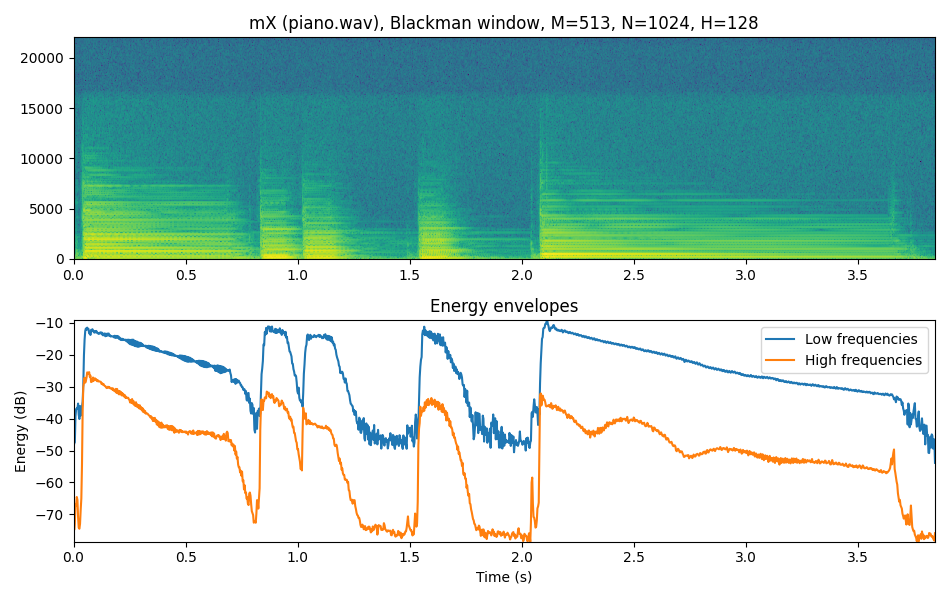

<ipython-input-7-7a934b25a2a9>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX1), shading = 'flat')


<IPython.core.display.Javascript object>


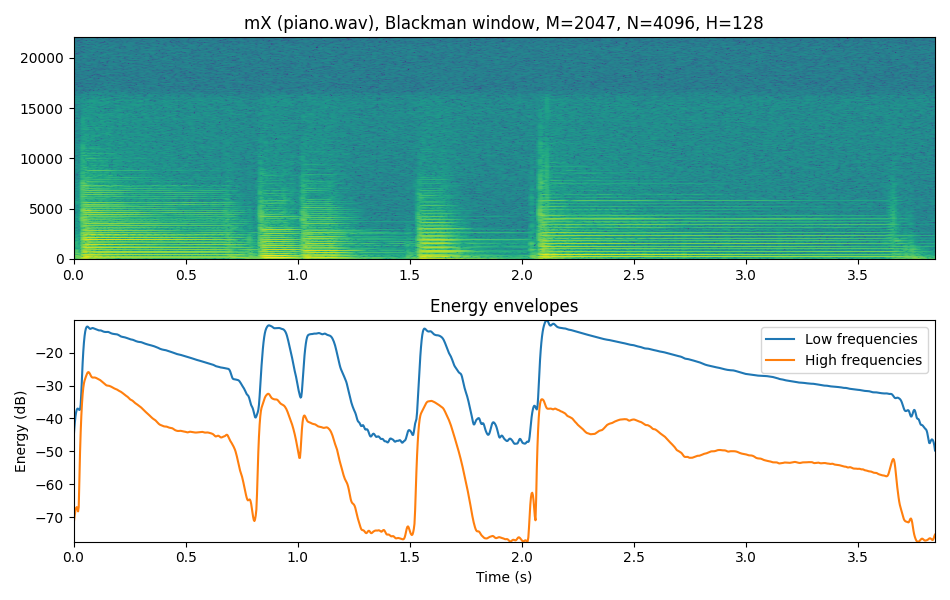

<ipython-input-7-7a934b25a2a9>:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX2), shading = 'flat')


<IPython.core.display.Javascript object>


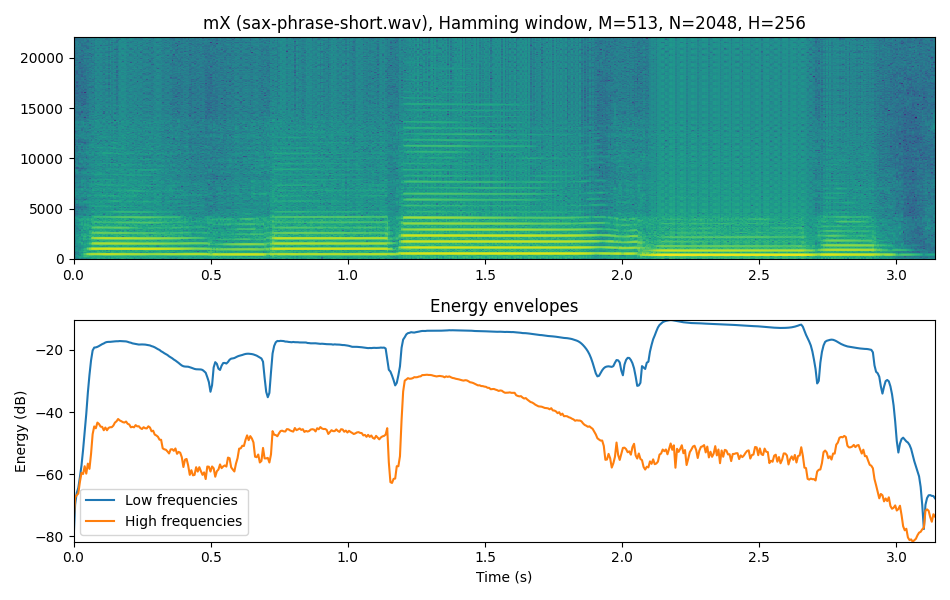

<ipython-input-7-7a934b25a2a9>:80: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX3), shading = 'flat')


In [7]:
# E4 - 3.2: Call the function compute_eng_env() and plot the envelopes together with the 
# spectrogram of the signal

### Your code here

### --------------------------------- TEST CASE 1 ------------------------------------ ###
input_file1 = '../sounds/piano.wav'
(fs1, x1) = UF.wavread(input_file1)                                                    # Read input file
M1 = 513                                                                               # Window size
N1 = 1024                                                                              # FFT size
H1 = 128                                                                               # Hop size
mX1, E_bandWise1 = compute_eng_env(input_file1, 'blackman', M=M1, N=N1, H=H1)          # Compute energy envelopes

# Plot spectrogram
plt.figure(figsize=(9.5, 6))
plt.subplot(2,1,1)
numFrames = int(mX1[:,0].size)
frmTime = H1*np.arange(numFrames)/float(fs1)                             
binFreq = np.arange(N1/2+1)*float(fs1)/N1                       
plt.pcolormesh(frmTime, binFreq, np.transpose(mX1), shading = 'flat')
plt.title('mX (piano.wav), Blackman window, M=513, N=1024, H=128')
plt.autoscale(tight=True)

# Plot energy envelopes
plt.subplot(2,1,2)
plt.plot(frmTime, E_bandWise1[:,0], label='Low frequencies')
plt.plot(frmTime, E_bandWise1[:,1], label='High frequencies')
plt.axis([0, max(frmTime), np.min(E_bandWise1), np.max(E_bandWise1)])
plt.legend()
plt.title('Energy envelopes')
plt.xlabel('Time (s)')
plt.ylabel('Energy (dB)')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### --------------------------------- TEST CASE 2 ------------------------------------ ###
M2 = 2047                                                                              # Window size
N2 = 4096                                                                              # FFT size
H2 = 128                                                                               # Hop size
mX2, E_bandWise2 = compute_eng_env(input_file1, 'blackman', M=M2, N=N2, H=H2)          # Compute energy envelopes (input file is the same as test case 1)

# Plot spectrogram
plt.figure(figsize=(9.5, 6))
plt.subplot(2,1,1)
numFrames = int(mX2[:,0].size)
frmTime = H2*np.arange(numFrames)/float(fs1)                             
binFreq = np.arange(N2/2+1)*float(fs1)/N2                       
plt.pcolormesh(frmTime, binFreq, np.transpose(mX2), shading = 'flat')
plt.title('mX (piano.wav), Blackman window, M=2047, N=4096, H=128')
plt.autoscale(tight=True)

# Plot energy envelopes
plt.subplot(2,1,2)
plt.plot(frmTime, E_bandWise2[:,0], label='Low frequencies')
plt.plot(frmTime, E_bandWise2[:,1], label='High frequencies')
plt.axis([0, max(frmTime), np.min(E_bandWise2), np.max(E_bandWise2)])
plt.legend()
plt.title('Energy envelopes')
plt.xlabel('Time (s)')
plt.ylabel('Energy (dB)')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### --------------------------------- TEST CASE 3 ------------------------------------ ###
input_file3 = '../sounds/sax-phrase-short.wav'
(fs3, x3) = UF.wavread(input_file3)                                                    # Read input file
M3 = 513                                                                               # Window size
N3 = 2048                                                                              # FFT size
H3 = 256                                                                               # Hop size
mX3, E_bandWise3 = compute_eng_env(input_file3, 'hamming', M=M3, N=N3, H=H3)           # Compute energy envelopes

# Plot spectrogram
plt.figure(figsize=(9.5, 6))
plt.subplot(2,1,1)
numFrames = int(mX3[:,0].size)
frmTime = H3*np.arange(numFrames)/float(fs3)                             
binFreq = np.arange(N3/2+1)*float(fs3)/N3                     
plt.pcolormesh(frmTime, binFreq, np.transpose(mX3), shading = 'flat')
plt.title('mX (sax-phrase-short.wav), Hamming window, M=513, N=2048, H=256')
plt.autoscale(tight=True)

# Plot energy envelopes
plt.subplot(2,1,2)
plt.plot(frmTime, E_bandWise3[:,0], label='Low frequencies')
plt.plot(frmTime, E_bandWise3[:,1], label='High frequencies')
plt.axis([0, max(frmTime), np.min(E_bandWise3), np.max(E_bandWise3)])
plt.legend()
plt.title('Energy envelopes')
plt.xlabel('Time (s)')
plt.ylabel('Energy (dB)')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


## Part 4 - Computing onset detection function

The function `compute_odf()` should compute a simple onset detection function (ODF) using the STFT. It should compute two ODFs one for each of the frequency bands, low and high. The low frequency band is the set of all the frequencies between 0 and 3000 Hz and the high frequency band is the set of all the frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). 

Start with an initial condition of `ODF(0) = 0` in order to make the length of the ODF same as that of the energy envelope. Remember to apply a half wave rectification on the ODF. 

The input arguments to the function are the wav file name including the path (`input_file`), window 
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a numpy 
array with two columns, where the first column is the ODF computed on the low frequency band and the 
second column is the ODF computed on the high frequency band.

Use `stftAnal()` to obtain the magnitude spectra for all the audio frames. Then compute the band-wise energy envelope for each frequency band specified. Finally compute the half wave rectify version of ODF from each energy envelope.


In [8]:
# E4 4.1: Complete function compute_odf()

def compute_odf(input_file, window, M, N, H):
    """Compute a simple onset detection function (ODF) using the STFT.
    
    Args:
        input_file (str): input sound file (monophonic with sampling rate of 44100)
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window size (odd integer value)
        N (int): fft size (power of two, bigger or equal than than M)
        H (int): hop size for the STFT computation
        
    Result:
            np.array: magnitude spectra of sound (2D array)
            np.array: D numpy array with ODF computed in band 0 < f < 3000 Hz (in dB) in first column, [:,0]
            np.array: ODF computed of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    
    mX, E_bandWise = compute_eng_env(input_file, window, M=M, N=N, H=H)       # Compute band-wise energy envelopes
    nFrames = E_bandWise.shape[0]                                             # Number of frames
    ODF_lowFreq = np.zeros(nFrames)                                           # Initialize ODF for low frequencies
    ODF_highFreq = np.zeros(nFrames)                                          # Initialize ODF for high frequencies
    
    for l in range(1, nFrames):                                               # Main loop to compute ODF (ODF(0) = 0)
        ODF_lowFreq[l] = E_bandWise[l,0] - E_bandWise[l-1,0]                  # ODF for low frequencies
        ODF_highFreq[l] = E_bandWise[l,1] - E_bandWise[l-1,1]                 # ODF for high frequencies
    
    for l in range(nFrames):                                                  # Half wave rectify
        if ODF_lowFreq[l] <= 0:                                               # Low frequencies
            ODF_lowFreq[l] = 0
        if ODF_highFreq[l] <= 0:                                              # High frequencies
            ODF_highFreq[l] = 0
    
    ODF = np.zeros((nFrames,2))                                               # Build output array (number of rows is number of frames)
    ODF[:,0] = ODF_lowFreq                                                    # First column is ODF of low frequency band
    ODF[:,1] = ODF_highFreq                                                   # Second column is ODF of high frequency band
    
    return mX, ODF                                                            # Return magnitude spectrum and ODF


Test cases for the function `compute_odf()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples). 

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples). 

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the ODFs and their characteristics you can plot the ODF functions together with the spectrogram of the signal. Use the same plotting than in the previos part.

In order to identify the actual onsets of a signal you would need to find the peaks, local maxima, of the ODF functions using a magnitude threshold. Which of the 2 ODFs (low or high frequencies) would be most useful? What would be the right threshold for all 3 cases? Could you find a single threshold to be used for all 3 cases?

For test case 1, you should clearly see that the ODFs have sharp peaks at the onset of the piano notes. You should notice 5 peaks that are above 10dB value in the ODF computed on the high frequency band. 

<IPython.core.display.Javascript object>


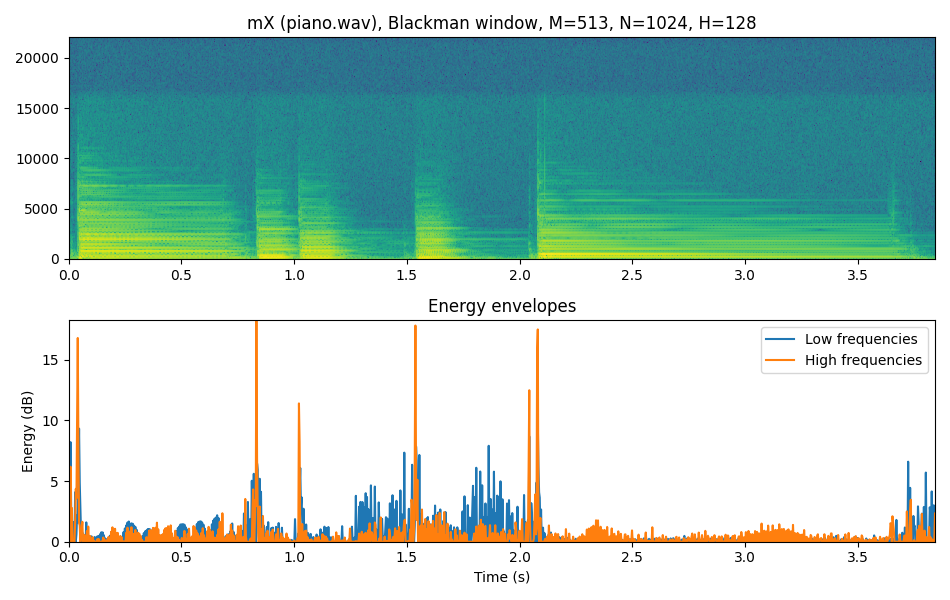

<ipython-input-9-9d7fe522be84>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX1), shading = 'flat')


<IPython.core.display.Javascript object>


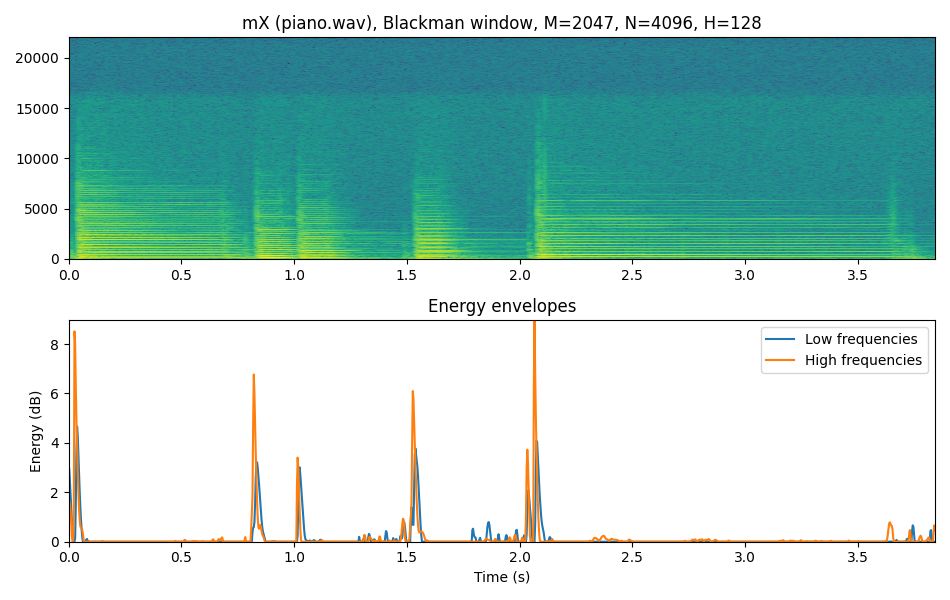

<ipython-input-9-9d7fe522be84>:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX2), shading = 'flat')


<IPython.core.display.Javascript object>


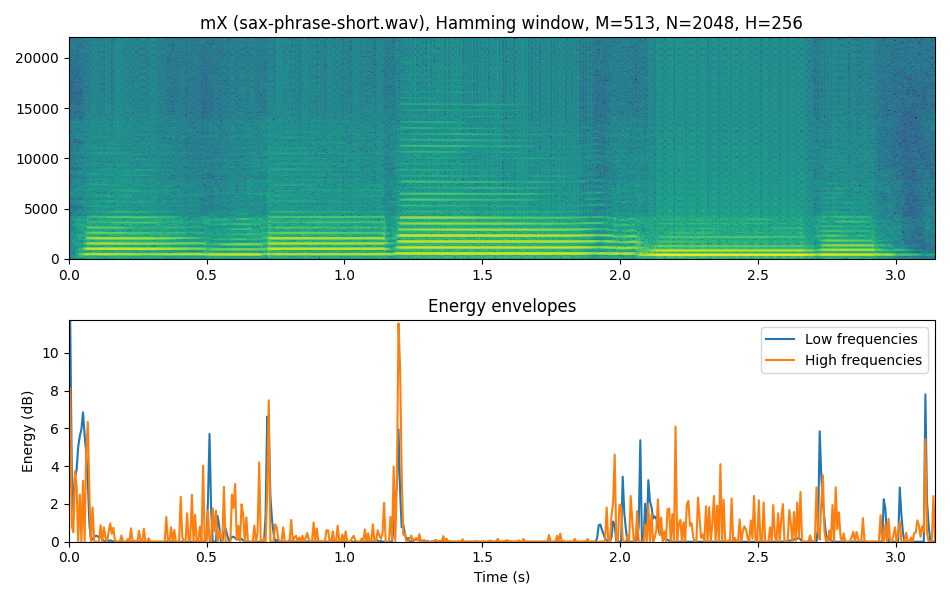

<ipython-input-9-9d7fe522be84>:90: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX3), shading = 'flat')


In [9]:
# E4 - 4.2: Call the function compute_odf() for the 3 test cases and plot the ODF functions together with the 
# spectrogram of the signal.

### Your code here

### ---------------------- TEST CASE 1 -------------------------------- ###
input_file1 = '../sounds/piano.wav'
(fs1, x1) = UF.wavread(input_file1)                                     # Read input file
M1 = 513                                                                # Window size
N1 = 1024                                                               # FFT size
H1 = 128                                                                # Hop size

# Compute ODF
mX1, ODF_1 = compute_odf(input_file1, 'blackman', M=M1, N=N1, H=H1)

# Plot spectrogram
plt.figure(figsize=(9.5, 6))
plt.subplot(2,1,1)
numFrames = int(mX1[:,0].size)
frmTime = H1*np.arange(numFrames)/float(fs1)                             
binFreq = np.arange(N1/2+1)*float(fs1)/N1                       
plt.pcolormesh(frmTime, binFreq, np.transpose(mX1), shading = 'flat')
plt.title('mX (piano.wav), Blackman window, M=513, N=1024, H=128')
plt.autoscale(tight=True)

# Plot ODF
plt.subplot(2,1,2)
plt.plot(frmTime, ODF_1[:,0], label='Low frequencies')
plt.plot(frmTime, ODF_1[:,1], label='High frequencies')
plt.axis([0, max(frmTime), np.min(ODF_1), np.max(ODF_1)])
plt.legend()
plt.title('Energy envelopes')
plt.xlabel('Time (s)')
plt.ylabel('Energy (dB)')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


### ---------------------- TEST CASE 2 -------------------------------- ###
input_file2 = '../sounds/piano.wav'
(fs2, x2) = UF.wavread(input_file2)                                     # Read input file
M2 = 2047                                                               # Window size
N2 = 4096                                                               # FFT size
H2 = 128                                                                # Hop size

# Compute ODF
mX2, ODF_2 = compute_odf(input_file2, 'blackman', M=M2, N=N2, H=H2)

# Plot spectrogram
plt.figure(figsize=(9.5, 6))
plt.subplot(2,1,1)
numFrames = int(mX2[:,0].size)
frmTime = H2*np.arange(numFrames)/float(fs2)                             
binFreq = np.arange(N2/2+1)*float(fs2)/N2                       
plt.pcolormesh(frmTime, binFreq, np.transpose(mX2), shading = 'flat')
plt.title('mX (piano.wav), Blackman window, M=2047, N=4096, H=128')
plt.autoscale(tight=True)

# Plot ODF
plt.subplot(2,1,2)
plt.plot(frmTime, ODF_2[:,0], label='Low frequencies')
plt.plot(frmTime, ODF_2[:,1], label='High frequencies')
plt.axis([0, max(frmTime), np.min(ODF_2), np.max(ODF_2)])
plt.legend()
plt.title('Energy envelopes')
plt.xlabel('Time (s)')
plt.ylabel('Energy (dB)')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


### ---------------------- TEST CASE 3 -------------------------------- ###
input_file3 = '../sounds/sax-phrase-short.wav'
(fs3, x3) = UF.wavread(input_file3)                                     # Read input file
M3 = 513                                                                # Window size
N3 = 2048                                                               # FFT size
H3 = 256                                                                # Hop size

# Compute ODF
mX3, ODF_3 = compute_odf(input_file3, 'hamming', M=M3, N=N3, H=H3)

# Plot spectrogram
plt.figure(figsize=(9.5, 6))
plt.subplot(2,1,1)
numFrames = int(mX3[:,0].size)
frmTime = H3*np.arange(numFrames)/float(fs3)                             
binFreq = np.arange(N3/2+1)*float(fs3)/N3                       
plt.pcolormesh(frmTime, binFreq, np.transpose(mX3), shading = 'flat')
plt.title('mX (sax-phrase-short.wav), Hamming window, M=513, N=2048, H=256')
plt.autoscale(tight=True)

# Plot ODF
plt.subplot(2,1,2)
plt.plot(frmTime, ODF_3[:,0], label='Low frequencies')
plt.plot(frmTime, ODF_3[:,1], label='High frequencies')
plt.axis([0, max(frmTime), np.min(ODF_3), np.max(ODF_3)])
plt.legend()
plt.title('Energy envelopes')
plt.xlabel('Time (s)')
plt.ylabel('Energy (dB)')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
# E4 - 4.3: Explain the results of Part 4
'''
For the first piano test case, it is very clear that the ODF for the high frequencies is more useful for determining
the onsets than the ODF for the low frequencies. However, for the sax sound, it is quite unclear since the peaks for 
both ODFs have similar heights. We can notice for this sax case that there are several peaks in the ODF for high 
frequencies which do not correspond to onsets, but the ODF for low frequencies here seems to produce peaks which 
correspond better to the position of the onsets, although some spurious peaks also appear. 

In order to determine the onsets, for each case we would need to set a different threhold. For instance, in the 
first test case, a relatively good threhold would be 10 dB (although there is one peak around 2.0 s just before 
the last onset that would be identified as onset when it is not). For the second test case, the ODFs are less noisy 
but the peaks have less energy than for the first test case. Here, it might be more reasonable to use the ODF for 
low frequencies since this spurious peak that also appeared in the test case 1 (just before the last onset) is 
lower than the rest of the onset peaks, thus we could identify all the correct onsets putting a threshold of 2.3 dB
for example (for the high frequency ODF this spurious peak is higher than one of the real onsets). For the third 
test case, it is very unclear which threhold could be used to determine the onsets, because there are too many 
spurious peaks in the last part of the sound.  

'''
